<a href="https://colab.research.google.com/github/kevinkhu/satconned/blob/main/satconned_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimate satellite constellation passes over a field of view
#### This program is agnostic to observer and target location. It can only provide an order-of-magnitude estimate of satellite passes based on the probability of a randomly oriented satellite at a given altitude above Earth will cross over a given field-of-view.

In [1]:
# Import important libraries
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.stats import binom
import scipy.integrate as integrate
import numpy as np
import astropy.constants as const
import astropy.units as u

# Setup some plotting properties
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)
rc('figure', figsize=[16,9])
rc('font', size=28)
rc('axes', linewidth=2)

rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 2
rcParams["xtick.major.top"] = True
rcParams["xtick.major.pad"] = 10
rcParams["xtick.top"] = True
rcParams["xtick.direction"] = "in"

rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 2
rcParams["ytick.major.right"] = True
rcParams["ytick.major.pad"] = 10
rcParams["ytick.right"] = True
rcParams["ytick.direction"] = "in"

## Function to estimate how many randomly generated satellites will pass over a given field-of-view

In [2]:
def satconned_geo(Satellite_altitude, FOV, Observation_duration, Number_of_satellites, Latitude_limit=90):
    """ Computes number of satellite passes within a region over the duration of an observation
    
    Parameters
    ----------
    Satellite_altitude : float
        Orbital altitude of satellites (km).
    FOV : float
        Field-of-view or avoidance radius (arcminutes)
    Observation_duration : float
        Duration of observation (hours)
    Number_of_satellites : float
        Total number of satellites to simulate
    Latitude_limit : float, optional
        Assume satellites orbit within +/- latitude limit (degrees)

    Returns
    -------
    Satcon : array
        Probability distribution of number of satellite passes over field-of-view
    Median_satcon: float
        Median number of satellite passes
    Stdev_satcon: float
        Standard deviation of satellite passes
    """
    Satellite_orbital_radius = (Satellite_altitude*u.km).to(u.m)+const.R_earth # Orbital altitude of satellites+Earth radius
    Satellite_velocity = np.sqrt(const.G*const.M_earth/Satellite_orbital_radius) # Velocity of satellites at Satellite_altitude
    Satellite_orbital_period = ((2*np.pi*(Satellite_orbital_radius))/Satellite_velocity).value # Satellite orbital period (minutes)

    Avoidance_radius= 2*np.pi*(FOV/60)/180 # Compute cone of avoidance
    Time_observation = Observation_duration*60*60 # Observation time hours to seconds
    Orbit_multiplier = Time_observation/Satellite_orbital_period # Number of times an individual satellite passes within observation duration
    
    #If there is a satellite latitude limit, calculate total number of steradians 
    Coaltitude1 = 90-np.abs(Latitude_limit)
    Coaltitude2 = np.abs(Latitude_limit)+90
    Steradians = 2*np.pi*integrate.quad(lambda x: np.sin(x), np.deg2rad(Coaltitude1), np.deg2rad(-Coaltitude2))[0]

    Relative_area_affected = np.clip(Time_observation, 0, Satellite_orbital_period)/Satellite_orbital_period * 2*np.pi*Avoidance_radius  / Steradians

    Satcon=np.random.binomial(Number_of_satellites, Relative_area_affected, 20000)*Orbit_multiplier
    Median_satcon = np.median(Satcon)
    Stdev_satcon = np.std(Satcon)
    return Satcon, print('Number of satellite passes: ',round(Median_satcon),'+/-',round(Stdev_satcon))

## Run the function above assuming a satellite altitude of 550 km, 15 arcminute field-of-view, 5 hour observation, 3000 satellites, and a satellite orbit limit of +/- 50 degrees latitude

Number of satellite passes:  53 +/- 13


Text(0, 0.5, 'Density')

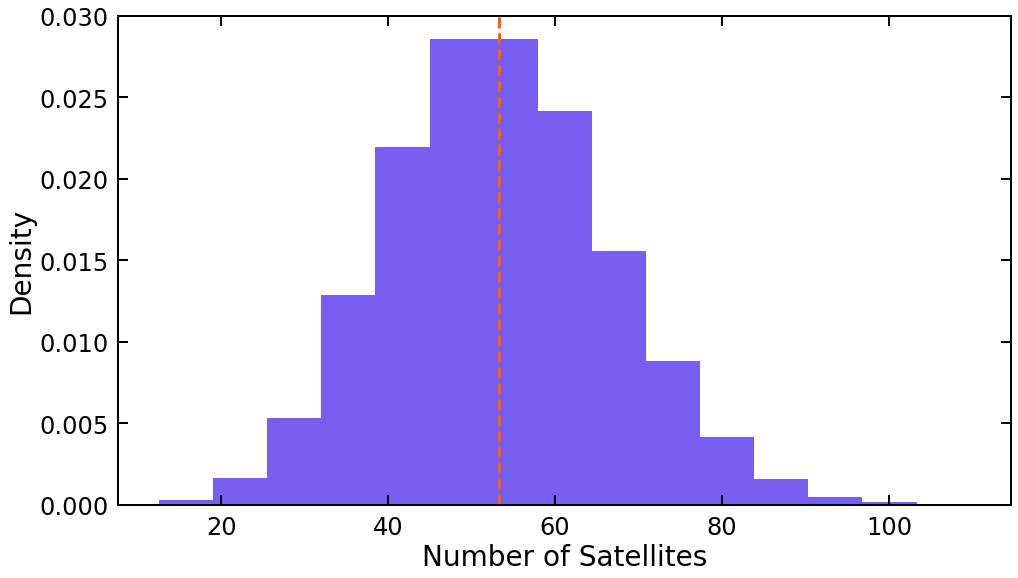

In [3]:
sc = satconned_geo(550, 15, 5, 3000, 50)[0]

# Plot resultant probability distribution
plt.hist(sc,color='#785EF0',bins=15,density=True)
plt.axvline(np.median(sc),color='#FE6100',ls='--',lw=3)
plt.xlabel('Number of Satellites')
plt.ylabel('Density')